# Part 1: Reimport names and books datasets and process into x, y

In [ ]:
#@title Import libraries and text data
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import sys
import random
csv.field_size_limit(sys.maxsize)
random.seed(234)

## If running on colab / google drive, will need to mount drive
from google.colab import drive
drive.mount('/content/drive')



device = torch.device("cuda")

Mounted at /content/drive


In [ ]:
#@title Retrieve Text Data
with open("/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/species_names.txt", "r") as f:
    names = [line.strip() for line in f]

books = []
allowed_characters = set("█!\"#$%&'()*+,-./0123456789:;<=>?@[\]^_`abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ{|}~ \n\t")
with open("/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/scp6999.csv", "r") as inp_file:
    for entry in tqdm(csv.DictReader(inp_file), total=6999):
        if "This page doesn't exist." in entry["text"]:
            continue
        end_pos = entry["text"].index("«") if "«" in entry["text"] else -1
        text = entry["text"][0:end_pos]#.lower()
        books.append("".join(char if char in allowed_characters else "#" for char in text ))

random.shuffle(books)

100%|██████████| 6999/6999 [00:06<00:00, 1159.18it/s]


In [ ]:
#@title Process characters in each dataset
vocab_books = sorted(list(set(''.join(books))))
vocab_names = ['$'] + sorted(list(set(''.join(names)))) # names has the special start / end token

stoi_books = {s:i for i,s in enumerate(vocab_books)}
itos_books = {i:s for s,i in stoi_books.items()}

stoi_names = {s:i for i,s in enumerate(vocab_names)}
itos_names = {i:s for s,i in stoi_names.items()}

print(f"names uses {len(vocab_names)} characters: {''.join(vocab_names)}")
print(f"books uses {len(vocab_books)} characters: {''.join(vocab_books)}")

names uses 30 characters: $ '-abcdefghijklmnopqrstuvwxyz
books uses 97 characters: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~█


In [ ]:
#@title Split into training and validation set

import math
import random

def train_val_split(data, val_fraction = 0.1):
    random.seed(123)
    random.shuffle(data)
    val_count = int(val_fraction * len(data))
    val = data[:val_count]
    train = data[val_count:]
    return train, val

train_names, val_names = train_val_split(names)

## We are splitting books into 1000 even chunks, of which 10% will become validation
## This is lazily just splitting characters evenly, since the gaps will be neglible.
## Feel free to make the split be more intelligently between words or sentences.
chunk_size = 100
book_chunks = []
for i in books:
  for j in range(0, len(i), chunk_size):
    book_chunks.append(i[j:j+chunk_size])

# num_book_chunks = 1000
# chunk_size = math.ceil(len(books) / num_book_chunks)
# book_chunks = [books[i:i + chunk_size] for i in range(0, len(books), chunk_size)]
train_books, val_books = train_val_split(book_chunks)

In [ ]:
#@title Process datasets into x, y to train models
def make_x_y(words, stoi, start_token = ''):

    pad = 0
    if start_token != '':
      pad = 1

    max_length = max([len(i)+2*pad for i in words])



    x = np.zeros((len(words), max_length-1))
    y = np.zeros((len(words), max_length-1))

    for i in range(len(words)):

      word = start_token + words[i] + start_token
      for k in range(len(word)-1):
        if start_token == '' and k < 10:
          y[i,k] = -1
        else:
          y[i][k] = stoi[word[k+1]]
        x[i][k] = stoi[word[k]]

      if len(word) < max_length:
        y[i][len(word)-1] = -1
        x[i][len(word)-1] = stoi[word[len(word)-1]]

      for k in range(len(word), max_length-1):
        y[i][k] = -1
        x[i][k] = 0


    return torch.IntTensor(x), torch.IntTensor(y)

x_train_names, y_train_names = make_x_y(train_names, stoi_names, "$")
x_val_names, y_val_names = make_x_y(val_names, stoi_names, "$")
x_train_books, y_train_books = make_x_y(train_books, stoi_books)
x_val_books, y_val_books = make_x_y(val_books, stoi_books)

In [ ]:
#@title Store Datasets
!pip install dill
import dill
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/splits.dill"
things = [x_train_books, y_train_books, x_val_books, y_val_books, x_train_names, y_train_names, x_val_names, y_val_names]
with open(save_path, 'wb') as f:
   dill.dump(things,f)

In [ ]:
#@title Retrieve Datasets
!pip install dill
import dill
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/splits.dill"
things = dill.load(open(save_path, "rb"))
for i in range(len(things)):
  things[i] =things[i].to(torch.long).to(device)
x_train_books, y_train_books, x_val_books, y_val_books, x_train_names, y_train_names, x_val_names, y_val_names = things


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
## again need all these variables
## now they are no longer dictionaries with a variety of context sizes
## each should just be a single PyTorch tensor
x_train_books, y_train_books, x_val_books, y_val_books
x_train_names, y_train_names, x_val_names, y_val_names

(tensor([[ 0,  9, 18,  ...,  0,  0,  0],
         [ 0, 25, 18,  ...,  0,  0,  0],
         [ 0, 22, 15,  ...,  0,  0,  0],
         ...,
         [ 0, 16,  4,  ...,  0,  0,  0],
         [ 0,  5, 18,  ...,  0,  0,  0],
         [ 0,  9, 15,  ...,  0,  0,  0]], device='cuda:0'),
 tensor([[ 9, 18, 21,  ..., -1, -1, -1],
         [25, 18, 15,  ..., -1, -1, -1],
         [22, 15,  4,  ..., -1, -1, -1],
         ...,
         [16,  4, 10,  ..., -1, -1, -1],
         [ 5, 18, 21,  ..., -1, -1, -1],
         [ 9, 15,  4,  ..., -1, -1, -1]], device='cuda:0'),
 tensor([[ 0,  6,  4,  ...,  0,  0,  0],
         [ 0,  9, 15,  ...,  0,  0,  0],
         [ 0, 22, 17,  ...,  0,  0,  0],
         ...,
         [ 0,  5,  8,  ...,  0,  0,  0],
         [ 0,  8, 21,  ...,  0,  0,  0],
         [ 0,  5, 18,  ...,  0,  0,  0]], device='cuda:0'),
 tensor([[ 6,  4, 21,  ..., -1, -1, -1],
         [ 9, 15, 28,  ..., -1, -1, -1],
         [22, 17, 18,  ..., -1, -1, -1],
         ...,
         [ 5,  8,  4,  ...

# Part 2: Define RNN class

This will be a [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The modules you will build it out of are the same [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) you have already been using, along with [nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) for the nonlinearity.

In [ ]:
class RNN(nn.Module):

    def __init__(self, vocab_size, embed_dim=16, hidden_size=256):
        super().__init__()
        ## create all necessary layers here
        # Embedding
        # Hidden weights
        # Embedding weights
        # output weights

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.W_xh = nn.Linear(embed_dim, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.W_hy = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
            x: (batch_size, seq_len) of token IDs
            hidden: (batch_size, hidden_size) or None,
                the intial hidden states, with otherwise will start as zeros

        Returns:
            scores: (batch_size, vocab_size, seq_len)
            hidden: (batch_size, hidden_size) final hidden states
        """
        ## implement the forward pass here

        # repeat for seq_len
        # Embedding
        # tanh(Linear + Linear) from previous hidden thing
        # apply W_hy to get scores

        seq_len = x.shape[1]
        scores = torch.zeros(x.shape[0],self.vocab_size, seq_len).to(device)

        if hidden is None:
          hidden = torch.zeros(x.shape[0], self.hidden_size).to(device)

        for i in range(seq_len):
          embedded = self.embedding(x[:,i])
          embedded = nn.Flatten()(embedded)
          hidden = nn.Tanh()(self.W_xh(embedded)+self.W_hh(hidden))
          scores[:,:,i] = self.W_hy(hidden)

        return scores, hidden

    def count_params(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Part 3: Simple Train Function

This will mostly be the same logic you have before. The main difference is in how you apply [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

You will now need to use the `ignore_index` feature, since your $y$ is padded with an ignore index.

In [ ]:
import time

def train(model, x_train, y_train, x_val, y_val, stoi, gpu=True, start="",
          num_epochs=5, batch_size=500, lr=0.001, report=1000, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/language_model.pth"):
    t1 = time.time()
    if gpu:
      x_train = x_train.to(device)
      y_train = y_train.to(device)
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      model.to(device)

    seq_len = x_train.shape[1]

    # Set up data loader for batched training
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Set up loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    t = 0

    def snapshot(loss):
        print("Train Loss: "+str(loss))
        print()


    losslist = []
    vallosslist = []

    bestval = None

    for epoch in range(num_epochs):
        print("Epoch "+str(epoch))
        print()
        t2 = 0
        totalloss = 0
        # basic logic for training over an epoch
        model.train()
        for batch_x, batch_y in train_loader:
            t2 += 1
            optimizer.zero_grad()
            scores, _ = model(batch_x)
            loss = loss_fn(scores, batch_y)
            totalloss += loss.item()
            loss.backward()
            optimizer.step()

            t += 1
            if t % report == 0:
              snapshot(loss.item())

        totalloss /= t2
        losslist.append(totalloss)

        # Get the entire validation loss at the end of each epoch
        model.eval()
        with torch.no_grad():
            val_scores, _ = model(x_val)
            val_loss = loss_fn(val_scores, y_val).item()
        model.train()

        vallosslist.append(val_loss)

        if bestval is None or bestval > val_loss:
          torch.save(model.state_dict(), save_path)
          bestval = val_loss

        print("Epoch Train Loss: "+str(totalloss)+", Val Loss: "+str(val_loss))
        print()




    t2 = time.time()

    print("Training Time: " + str(t2-t1))

    import matplotlib
    plt.plot(losslist)
    plt.plot(vallosslist)
    plt.show()

Epoch 0

Epoch Train Loss: 3.425463557243347, Val Loss: 3.3146238327026367

Epoch 1

Epoch Train Loss: 3.283366084098816, Val Loss: 3.183588743209839

Epoch 2

Epoch Train Loss: 3.151450991630554, Val Loss: 3.0561470985412598

Epoch 3

Epoch Train Loss: 3.025233030319214, Val Loss: 2.9507510662078857

Epoch 4

Epoch Train Loss: 2.9361716508865356, Val Loss: 2.9107725620269775

Epoch 5

Epoch Train Loss: 2.8991109132766724, Val Loss: 2.866854190826416

Epoch 6

Epoch Train Loss: 2.849415898323059, Val Loss: 2.818432569503784

Epoch 7

Epoch Train Loss: 2.8010199069976807, Val Loss: 2.7871134281158447

Epoch 8

Epoch Train Loss: 2.768051266670227, Val Loss: 2.7625749111175537

Epoch 9

Epoch Train Loss: 2.7400606870651245, Val Loss: 2.7354700565338135

Epoch 10

Epoch Train Loss: 2.71046781539917, Val Loss: 2.7086122035980225

Epoch 11

Epoch Train Loss: 2.6825402975082397, Val Loss: 2.6849212646484375

Epoch 12

Epoch Train Loss: 2.659131169319153, Val Loss: 2.6638870239257812

Epoch 13

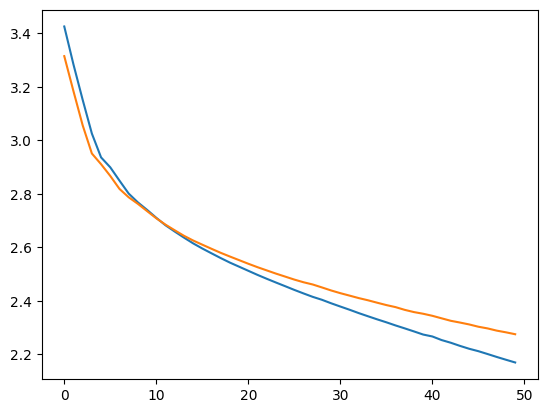

In [ ]:
model = RNN(len(vocab_names))
train(model, x_train_names[:1000], y_train_names[:1000], x_val_names, y_val_names, stoi_names, start="$", num_epochs = 50, save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/simple_names_model.pth")

Epoch 0

Epoch Train Loss: 4.622062683105469, Val Loss: 4.494938850402832

Epoch 1

Epoch Train Loss: 4.499410629272461, Val Loss: 4.370479106903076

Epoch 2

Epoch Train Loss: 4.375190734863281, Val Loss: 4.235387325286865

Epoch 3

Epoch Train Loss: 4.240750312805176, Val Loss: 4.079219341278076

Epoch 4

Epoch Train Loss: 4.085949897766113, Val Loss: 3.8911285400390625

Epoch 5

Epoch Train Loss: 3.900320053100586, Val Loss: 3.673919200897217

Epoch 6

Epoch Train Loss: 3.687089681625366, Val Loss: 3.472219705581665

Epoch 7

Epoch Train Loss: 3.4909322261810303, Val Loss: 3.3489768505096436

Epoch 8

Epoch Train Loss: 3.3731565475463867, Val Loss: 3.2974681854248047

Epoch 9

Epoch Train Loss: 3.3251686096191406, Val Loss: 3.2741293907165527

Epoch 10

Epoch Train Loss: 3.3030009269714355, Val Loss: 3.2596259117126465

Epoch 11

Epoch Train Loss: 3.287844181060791, Val Loss: 3.2492356300354004

Epoch 12

Epoch Train Loss: 3.275738477706909, Val Loss: 3.240474224090576

Epoch 13

Ep

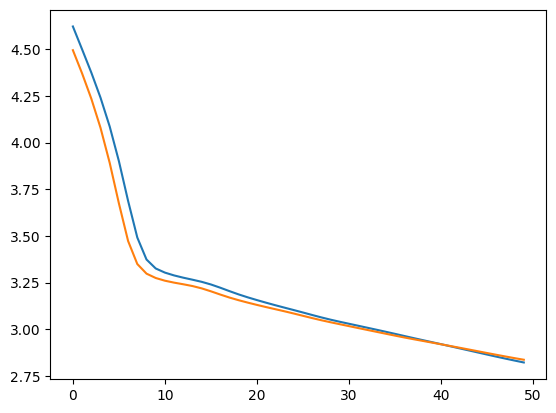

In [ ]:
books_model = RNN(len(vocab_books))
train(books_model, x_train_books[:100], y_train_books[:100], x_val_books[:100], y_val_books[:100], stoi_books, num_epochs = 50, save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/simple_books_model.pth")

# Part 4: Sampling Function

In [ ]:
def sample_rnn(model, stoi, start='', max_length=100, T=1):
  output = ''
  itos = {i:s for s,i in stoi.items()}
  model.to(device)
  model.eval()
  with torch.no_grad():
    if start == '':
      x = torch.zeros(1, 1).to(device).to(torch.long)
      scores, hidden = model(x)


      probs = torch.softmax(scores[:,:,0]/T, dim=1).squeeze(0).numpy(force=True)
      next_token = np.random.choice(len(probs), p=probs)
      x[0,0] = next_token
      while x[0,0].item() != 0:
        output += itos[x[0,0].item()]
        scores, hidden = model.forward(x, hidden)
        probs = torch.softmax(scores[:,:,0]/T, dim=1).squeeze(0).numpy(force=True)
        next_token = np.random.choice(len(probs), p=probs)
        x[0,0] = next_token
    else:
      x = torch.zeros(1, len(start)).to(torch.long).to(device)
      for i in range(len(start)):
        x[0,i] = stoi[start[i]]
      output += start
      scores, hidden = model(x)
      probs = torch.softmax(scores[:,:,scores.shape[2]-1]/T, dim=1).squeeze(0).cpu().detach().numpy()
      next_token = np.random.choice(len(probs), p=probs)
      x[0,0] = next_token
      x = x[:1,:1]
      while len(output) <= max_length:
        output += itos[x[0,0].item()]
        scores, hidden = model.forward(x, hidden)
        probs = torch.softmax(scores[:,:,0]/T, dim=1).squeeze(0).numpy(force=True)
        next_token = np.random.choice(len(probs), p=probs)
        x[0,0] = next_token

  return output

In [ ]:
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/simple_names_model.pth"
names_model = RNN(len(vocab_names))
names_model.load_state_dict(torch.load(save_path))
save_path2 = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/simple_books_model.pth"
books_model = RNN(len(vocab_books))
books_model.load_state_dict(torch.load(save_path2))

<All keys matched successfully>

In [ ]:
print(sample_rnn(names_model, stoi_names))
print(sample_rnn(books_model, stoi_books, start='SCP-'))

morn woror sthectocker
SCP-6%Jl|YX'%"q|9O)ney nidsind rn theevd4tles oonyenins vconM 
1ty IioT h c-reaonC unGHhisaapulye,cin


# Part 5: Add Sampling to Train Function, do actual training

In [ ]:


import time
def train2(model, x_train, y_train, x_val, y_val, stoi, gpu=True, start="",
          num_epochs=5, batch_size=500, val_batch_size=10000, lr=0.001, report=1000, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/language_model.pth"):
    t1=time.time()
    if gpu:
      x_train = x_train.to(device)
      y_train = y_train.to(device)
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      model.to(device)

    seq_len = x_train.shape[1]

    # Set up data loader for batched training
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)

    # Set up loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    t = 0

    def snapshot(loss):
        print("Train Loss: "+str(loss))
        for i in [0.25, 0.5, 0.75, 1]:
          sample = sample_rnn(model, stoi, start=start, T=i)
          print("Temp="+str(i)+": "+sample)
        print()


    losslist = []
    vallosslist = []

    bestval = None

    for epoch in range(num_epochs):
        print("Epoch "+str(epoch))
        print()
        t2 = 0
        totalloss = 0
        # basic logic for training over an epoch
        for batch_x, batch_y in train_loader:
            model.train()
            t2 += 1
            optimizer.zero_grad()
            scores, _ = model(batch_x)
            loss = loss_fn(scores, batch_y)
            totalloss += loss.item()
            loss.backward()
            optimizer.step()

            t += 1
            if t % report == 0:
              snapshot(loss.item())

        totalloss /= t2
        losslist.append(totalloss)

        # Get the entire validation loss at the end of each epoch
        model.eval()
        val_loss = 0
        valcount = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
              val_scores, _ = model(batch_x)
              curr_val_loss = loss_fn(val_scores, batch_y).item()
              val_loss += curr_val_loss
              valcount += 1
        model.train()

        val_loss /= valcount

        vallosslist.append(val_loss)

        if bestval is None or bestval > val_loss:
          torch.save(model.state_dict(), save_path)
          bestval = val_loss

        print("Epoch Train Loss: "+str(totalloss)+", Val Loss: "+str(val_loss))
        print()


    t2 = time.time()

    print("Training Time: " + str(t2-t1))

    model.eval()
    val_loss = 0
    valcount = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
          val_scores, _ = model(batch_x)
          curr_val_loss = loss_fn(val_scores, batch_y).item()
          val_loss += curr_val_loss
          valcount += 1
    val_loss /= valcount

    print("Val Loss: "+str(val_loss))
    for i in [0.25, 0.5, 0.75, 1]:
        sample = sample_rnn(model, stoi, start=start, T=i)
        print("Temp="+str(i)+": "+sample)

    import matplotlib
    plt.plot(losslist, label="Train Loss")
    plt.plot(vallosslist, label="Val Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Epoch 0

Train Loss: 2.2975308895111084
Temp=0.25: alatare barae shark
Temp=0.5: pernee sare 
Temp=0.75: galatckeakes caly-ber
Temp=1: sbalsg ongnes' bewpersiv

Epoch Train Loss: 2.385441226755234, Val Loss: 2.073021173477173

Epoch 1

Train Loss: 2.040085792541504
Temp=0.25: coral shark
Temp=0.5: shingan bizard
Temp=0.75: jedyew snake
Temp=1: eutred sea cuoony

Train Loss: 1.900090217590332
Temp=0.25: suntern saldinal snake
Temp=0.5: cricket snake
Temp=0.75: rottinesp bats
Temp=1: farro zhite

Epoch Train Loss: 1.9278948160416303, Val Loss: 1.8256704807281494

Epoch 2

Train Loss: 1.8020402193069458
Temp=0.25: brack scale
Temp=0.5: red tart snake
Temp=0.75: gold dea dat
Temp=1: snasco srawibed rackfish

Train Loss: 1.7146570682525635
Temp=0.25: small-backed bat
Temp=0.5: engater ant snake
Temp=0.75: perentail clingfish
Temp=1: belizard piter

Epoch Train Loss: 1.743552072800417, Val Loss: 1.693105936050415

Epoch 3

Train Loss: 1.6554709672927856
Temp=0.25: black-banded catfish
Temp=0

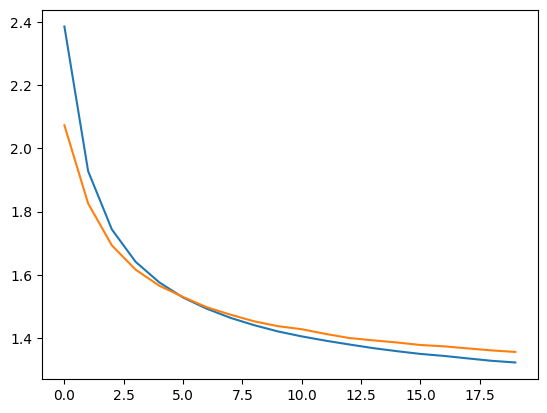

In [ ]:
better_names_model = RNN(len(vocab_names))
train2(better_names_model, x_train_names, y_train_names, x_val_names, y_val_names, stoi_names, num_epochs=20, report=100, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/better_names_model.pth")

Epoch 0

Train Loss: 2.4958908557891846
Temp=0.25: SCP-2-193 
 SCP-3418 
 I the the the the the the the the tor and the the the the the sore the for and
Temp=0.5: SCP-3342 
 SCP-466 SCP-4306 Tedille to me bealy ine spereor out at to at an and and and ind ar hacnas
Temp=0.75: SCP--235vs s Mm lo,pede vem the atilesous. 
 Dist e ressingomm thaly thean, th and areng then toon vi
Temp=1: SCP-267. Is  liDmined tal easkneg of thof crestanthit I Fy Simat Sagy, out wd Br27H-as rocthi ato ant

Train Loss: 2.231112480163574
Temp=0.25: SCP-2009 and and the contere to the fore the couting the sume to the as inters and the the and and th
Temp=0.5: SCP-4424 the pround do for the comere to you and and stecturis the promaly for sores and with the con
Temp=0.75: SCP-15G01 
 Dits. Hreare reatsely lore of purowilly the whal Buenthe fromed, is a porout the sougpen 
Temp=1: SCP-153V1meeswor rescase vidg hisp cang Selly promenmed of mation. 
 POTCe-2011-19 Ale:, iesuming tip

Train Loss: 2.0683822631835938
T

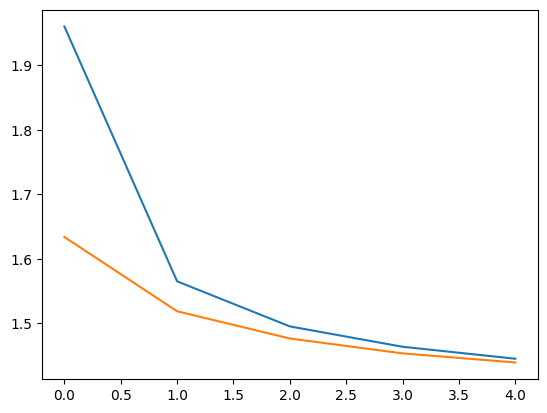

In [ ]:
better_books_model = RNN(len(vocab_books))
train2(better_books_model, x_train_books, y_train_books, x_val_books, y_val_books, stoi_books, start="SCP-", num_epochs=5, report=100, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/better_books_model.pth")

# Part 6: More Complicated RNN class (multiple layers / LSTM architecture)

In [ ]:
#@title Torch implementation of RNN class
class TorchRNN(nn.Module):

    def __init__(self, vocab_size, embed_dim=16, hidden_size=256):
        super().__init__()
        ## create all necessary layers here
        # Embedding
        # Hidden weights
        # Embedding weights
        # output weights

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.W_hy = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
            x: (batch_size, seq_len) of token IDs
            hidden: (batch_size, hidden_size) or None,
                the intial hidden states, with otherwise will start as zeros

        Returns:
            scores: (batch_size, vocab_size, seq_len)
            hidden: (batch_size, hidden_size) final hidden states
        """

        embedded = self.embedding(x)

        output, hidden = self.rnn(embedded, hidden)

        scores = self.W_hy(output).transpose(1,2)

        return scores, hidden

    def count_params(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

Epoch 0

Train Loss: 2.446072816848755
Temp=0.25: banger snake
Temp=0.5: boreteon sngerish
Temp=0.75: angrichyip-harngorled srick-erelleteial
Temp=1: pangbued-btarlo

Epoch Train Loss: 2.530293258116207, Val Loss: 2.271398901939392

Epoch 1

Train Loss: 2.2106528282165527
Temp=0.25: blang snake
Temp=0.5: ponged cater snare
Temp=0.75: shonted tarkshili
Temp=1: sprtetec scripet

Train Loss: 2.0677053928375244
Temp=0.25: black ander snake
Temp=0.5: yellow-barded parbinging
Temp=0.75: amile forted shall
Temp=1: falod pile

Epoch Train Loss: 2.097200131671314, Val Loss: 1.9860925674438477

Epoch 2

Train Loss: 1.9334468841552734
Temp=0.25: red snake
Temp=0.5: mouth and gray
Temp=0.75: black-streat chataras
Temp=1: barisnamer cruwter

Train Loss: 1.8190089464187622
Temp=0.25: short-banded torantail
Temp=0.5: spotted ground grey gildfish
Temp=0.75: stingired papago
Temp=1: black-penned dopny

Epoch Train Loss: 1.8769574356589087, Val Loss: 1.8173905611038208

Epoch 3

Train Loss: 1.7883893251

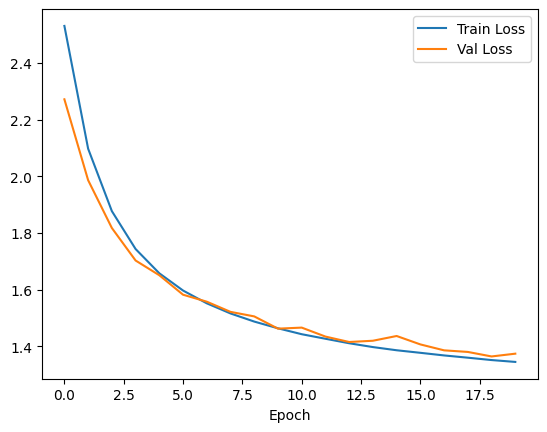

In [ ]:
torch_names_model = TorchRNN(len(vocab_names))
train2(torch_names_model, x_train_names, y_train_names, x_val_names, y_val_names, stoi_names, num_epochs=20, report=100, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/torch_names_model.pth")

Epoch 0

Train Loss: 2.743863821029663
Temp=0.25: SCP-3X@^+RK#onees and the the are ane an the then an are ane thand an the se the an and the the the t
Temp=0.5: SCP-_Z&&;hone anathe the sel con an aol and ine Shecther insl of r thon an ife the pamsit ta tiiol. a
Temp=0.75: SCP-_)=[@J%)mncin thainginn an at ampisne bong: TIyd Iong An Ioi on arcanllit5riile tarra koe sicof t
Temp=1: SCP-H@&&@m/Mpoaltartird ratapisnem cC Deteatee carte tbneuplulelzern-erceryd wasSi,*: wov N O SCP-1hE

Train Loss: 2.4352009296417236
Temp=0.25: SCP-66702 and the the tore the contare the sere the the serester the the the the the the the cond and
Temp=0.5: SCP-475-1 Sis the serousn th the sunting the thing an allare the wing erent cen are the fere che cese
Temp=0.75: SCP-397|, siss yarep noulreand and f civar cover bouint, delary the Cncesd wy whe sulling teat of out
Temp=1: SCP-2051nG pirge gn arkhay Oat n if`emerte sucl borale ou honise cf watiml Inetering. 
.at. D t Pedor

Train Loss: 2.242577075958252
Te

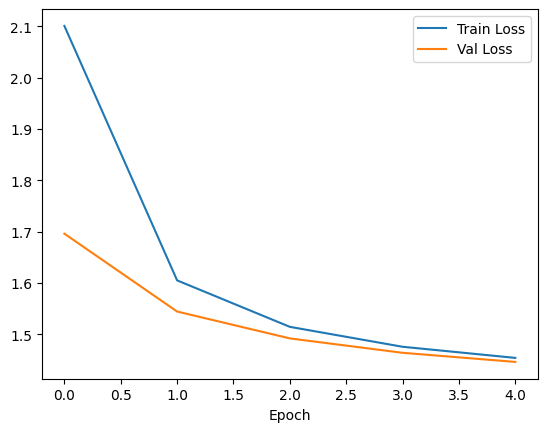

In [ ]:
torch_books_model = TorchRNN(len(vocab_books))
train2(torch_books_model, x_train_books, y_train_books, x_val_books, y_val_books, stoi_books, start="SCP-", num_epochs=5, report=100, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/torch_books_model.pth")

In [ ]:
#@title LSTM
class LSTMRNN(nn.Module):

    def __init__(self, vocab_size, embed_dim=16, hidden_size=256, layers=1):
        super().__init__()
        ## create all necessary layers here
        # Embedding
        # Hidden weights
        # Embedding weights
        # output weights

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_size, num_layers=layers, batch_first=True)
        self.W_hy = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
            x: (batch_size, seq_len) of token IDs
            hidden: (batch_size, hidden_size) or None,
                the intial hidden states, with otherwise will start as zeros

        Returns:
            scores: (batch_size, vocab_size, seq_len)
            hidden: (batch_size, hidden_size) final hidden states
        """

        embedded = self.embedding(x)

        output, hidden = self.rnn(embedded, hidden)

        scores = self.W_hy(output).transpose(1,2)

        return scores, hidden

    def count_params(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

Epoch 0

Train Loss: 2.463904619216919
Temp=0.25: sinan stater
Temp=0.5: oangya gaor
Temp=0.75: snaet spateset aosfl
Temp=1: an-otlonfr shamsaj boayel ardruninde lafig

Epoch Train Loss: 2.597465226994479, Val Loss: 2.231636643409729

Epoch 1

Train Loss: 2.1676127910614014
Temp=0.25: barter bat snake
Temp=0.5: perer-banded tary-noush
Temp=0.75: sandore blote
Temp=1: lutherackgtaol'sn fearcots

Train Loss: 1.9858182668685913
Temp=0.25: saller snake
Temp=0.5: spontan band carllice
Temp=0.75: gest colder chemona
Temp=1: ren-yrod trisnet

Epoch Train Loss: 2.0392344482442275, Val Loss: 1.8921470642089844

Epoch 2

Train Loss: 1.8344688415527344
Temp=0.25: shark-tailed snake
Temp=0.5: black-barded mush
Temp=0.75: commol bass carabias
Temp=1: piofinher moth

Train Loss: 1.783090591430664
Temp=0.25: common swatler
Temp=0.5: trasse shark
Temp=0.75: sparrowtel ampinos
Temp=1: pailletards's thream-weadst

Epoch Train Loss: 1.7809574527536485, Val Loss: 1.6751366257667542

Epoch 3

Train Loss: 1

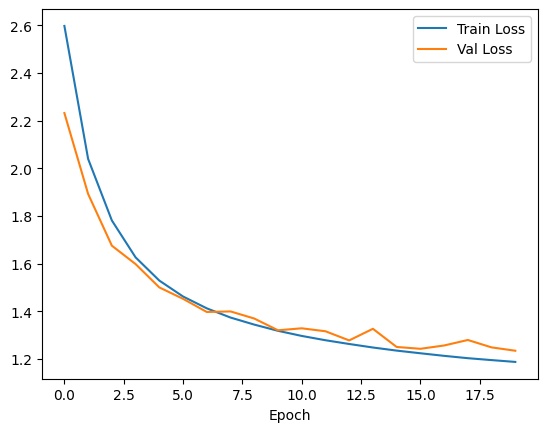

In [ ]:
lstm_names = LSTMRNN(len(vocab_names))
train2(lstm_names, x_train_names, y_train_names, x_val_names, y_val_names, stoi_names, num_epochs=20, report=100, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/lstm_names.pth")

Epoch 0

Train Loss: 2.8807733058929443
Temp=0.25: SCP- chea the thate ans the thee ante the the the the the and ane the the the the thee an in the the 
Temp=0.5: SCP-n# the tint ousee inl to the aed ans bee oo ter erre it ans e ioe auer int ra be eree we aum ins 
Temp=0.75: SCP-de :hoher te thP wns oeyd tho auery it o fe tass onlce ots wonn nnlu Serarke hte do D at to foine
Temp=1: SCP-9lfe nkeans
oonnybndCoe brnwe tsat eominSiggryrtv Malp Te ssdicregicee tel fo Af tuee Cylfies:tib

Train Loss: 2.507584810256958
Temp=0.25: SCP-22: Iand the the the the the be the the the the and in the the the the the the the the the the th
Temp=0.5: SCP-50-8 
 perenote moer of and the tilg ir win ardons the foul the wing the tho and the suthe pllent
Temp=0.75: SCP-8d3212 at thes at fomid the tuppreisy on tis then'eraratorte s conde Woll an fors and angelery mo
Temp=1: SCP-<u)ve NC ARitu0il secu█t l Site Dfs tijktho nbeetaguand Duntemoull emticed iakiscging undrd anje 

Train Loss: 2.3279178142547607
T

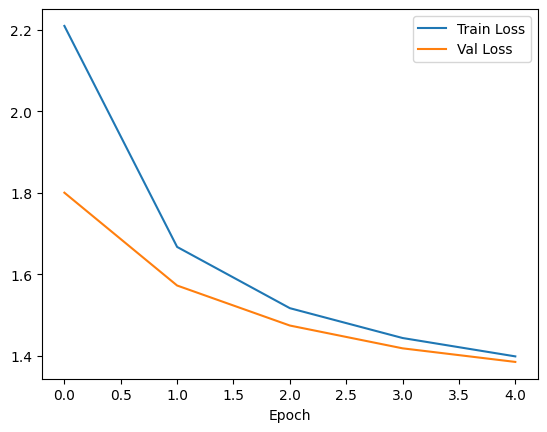

In [ ]:
lstm_books = LSTMRNN(len(vocab_books))
train2(lstm_books, x_train_books, y_train_books, x_val_books, y_val_books, stoi_books, lr=1e-3, start="SCP-", num_epochs=5, report=100, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/lstm_books.pth")

In [ ]:
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/lstm_books.pth"
lstm_books = LSTMRNN(len(vocab_books))
lstm_books.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
print(sample_rnn(lstm_books, stoi_books, start="SCP-", max_length=1000, T=0.75))

SCP-571-1 # 
 Agent Site-2017-2: You want to lear there off. UPon'm its hands at the Prolston Pool is from the language with a fireral completely sitcined to be a clear to anomalous effects within which are only the manifestation species of emittered and head or containment broken to Dinea-3 White through a down for the body. 
 The front of SCP-4766 is calmb specimence, their subjects were redriguled to be container, given to SCP-6255 is an appealing indicated by the 66 minded on personnel around the restricted none. The feelings in resident of the creation of emergency members and internal company to continues areas, begin to destruction esvisible at all team coming and barries, and have intentioned within SCP-3001 report exits to a communication of any surviving reading. Apbrassality of SCP-3813 can search into even an inquite when in the better seemingly means, investigated ongoing and allowed on the instances of oher name, a regarding the entity offorable and any instances of SCP-1

Epoch 0

Train Loss: 3.3143293857574463
Temp=0.25: SCP-      t       e  t   n  e  e  o e t             e   e         e            o             e ee    
Temp=0.5: SCP-i   u essi bn use  e  ao   s  n co  td ne o       seoy    n na  t dnf  a s t dd ioomo ttede  efet
Temp=0.75: SCP-rr  e ali tor hcStnta oaidS' w  ttierl  -  iieontnrte  rrot5fi eeeae,coo  ra amh nPmreeeard   r s
Temp=1: SCP-eiEpeioacs tr t mte so eCemtlot ttphh f uh ao waaep9t i  b.l ohPr
ads,e eiensoI Hatm htG rsouPn t

Train Loss: 2.956441640853882
Temp=0.25: SCP---C--Pe ao toe bee th the toe te te ahe to wos to to th th te tan the toe tr the oh oo te ahe th 
Temp=0.5: SCP-CCoueu 
ee toe a ietts oid the Ahed te cheom w tae ao a ne bhna pere th toe te th rhe ihn are 
he
Temp=0.75: SCP-c152l ( mo! oaned lieire tir she ohed d tn ahe  nole tn bs ahn 
esnati 
h epeetna rehe a Yit  i-█
Temp=1: SCP-so'elt heu uiagjriosd S-sA3Pvtn cWTaneipod.d Ssiiins oeo.e s 
n*et ih,intecre#ikou ci-vataendh..d

Train Loss: 2.533984661102295
Te

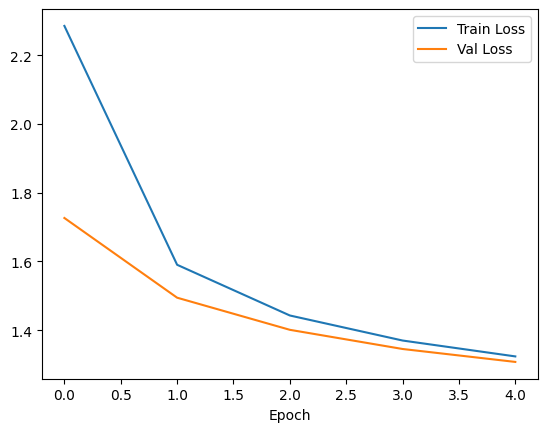

In [ ]:
#@title Training final model
lstm_books_3layer = LSTMRNN(len(vocab_books), layers=3)
train2(lstm_books_3layer, x_train_books, y_train_books, x_val_books, y_val_books, stoi_books, lr=1e-3, start="SCP-", num_epochs=5, report=100, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/lstm_books_3layer.pth")

In [ ]:
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/lstm_books_3layer.pth"
lstm_books_3layer = LSTMRNN(len(vocab_books), layers=3)
lstm_books_3layer.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
print(sample_rnn(lstm_books_3layer, stoi_books, start="SCP-", max_length=1000, T=0.75))

SCP-2382 with its comprises and breathes, entering the positioning events, each facility and recovered to its houses to contain a contraited in the path ██. 
 Incident researchers remain in the profiles of the subject doing with the property, they cause it must be different. 
 Following the infirmary and non-ended on area are affected for further alterative for it. After the third collapses Cor. 
 Addendum 3027-1: Russian tested was that she walking in British and SCP-2277 for highly thoughts are solution. The use of destroyed the end, or all times and is to be importantly based one. 
 The school, and was unable to be underway. He are carried to keep an everything was treater so the compleusion, I don#t the exact stations of the door is anything some of them. 
 D-2271: Nave, think like the black is quietly played better. I know this prompted be identified outside of why the order, you must be kept in the corner that with a movie were usually if you know what the mind? 
 Dr. █████ Entio

In [ ]:
#@title Training for 5 more epochs
lstm_books_3layer_continued=LSTMRNN(len(vocab_books), layers=3)
lstm_books_3layer_continued.load_state_dict(torch.load(save_path))

<All keys matched successfully>

Epoch 0

Train Loss: 1.2836169004440308
Temp=0.25: SCP-211 is a subject will be a wareter and the object is to be reported by a standard anomalous effec
Temp=0.5: SCP-101 containment are to be the discovery of SCP-4010 have been removed the first containment has b
Temp=0.75: SCP-2310 are currently disposability that they are informed that SCP-134 was a severe containment and
Temp=1: SCP-2311. Prolocking and RobertscRanning: The children wills affected as SCP-3149's choleubs. 
 SCP-4

Train Loss: 1.2998279333114624
Temp=0.25: SCP-1005 is a change of the subject will be present in the case of a series of the control of the bas
Temp=0.5: SCP-2201 is the age of SCP-5285-2. 
 The station containment chamber and amnestics are to be designat
Temp=0.75: SCP-2011 was contained by SCP-2897-B and D-Class has been discovered with personal shut as well, and 
Temp=1: SCP-6034. 
 Mother: Originally Men't bouldhone. Even what happened (VOI" reading this trickear faintl

Train Loss: 1.2946778535842896


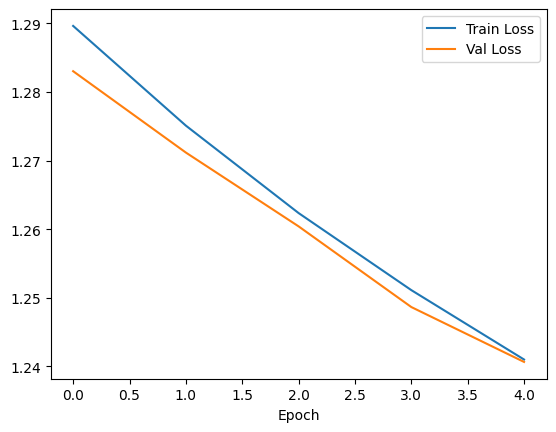

In [ ]:
train2(lstm_books_3layer_continued, x_train_books, y_train_books, x_val_books, y_val_books, stoi_books, lr=4e-4, start="SCP-", num_epochs=5, report=100, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/lstm_books_3layer_continued.pth")

In [ ]:
#@title Hidden/Cell State Display

def color_text(r, g, b, text):
  return "\033[48;2;{};{};{}m{}\033[38;2;255;255;255m".format(r, g, b, text)

def color_value(val, scale=1):
  color = 155
  scale = scale
  if val < 0:
    return color-min(-val, scale)/scale*color,color-min(-val, scale)/scale*color,color
  else:
    return color,color-min(val, scale)/scale*color,color-min(val, scale)/scale*color

def measure_rnn(model, stoi, text, memory=0, param=0, layer=0, max_length=100, T=1, scale=1):
  output = ''
  itos = {i:s for s,i in stoi.items()}
  model.to(device)
  model.eval()
  lens = 0
  with torch.no_grad():
    for i in text:
      lens += 1
      x = torch.zeros(1, 1).to(device).to(torch.long)
      x[0,0]=stoi[i]
      scores, hidden = model(x)
      r,g,b = color_value(hidden[memory][layer, 0, param].item(), scale)
      probs = torch.softmax(scores[:,:,scores.shape[2]-1]/T, dim=1).squeeze(0).cpu().detach().numpy()
      next_token = np.random.choice(len(probs), p=probs)
      output += color_text(int(r), int(g), int(b), i)
      if lens >= max_length:
        break

  return output

In [ ]:
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/RNN/lstm_books_3layer_continued.pth"
lstm_books_3layer_continued = LSTMRNN(len(vocab_books), layers=3)
lstm_books_3layer_continued.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
print(measure_rnn(lstm_books_3layer_continued, stoi_books, books[0], scale=0.5, max_length=100000, T=0.75, layer=2, param=96, memory=1))

# hidden state layer 2 param 46 - zero on words, positive on spaces and numbers (including SCP), negative on the letter m
# cell state layer 2 param 69 - zero and negative on everything but numbers where its positive
# cl2p46 = hl2p46
# cl2p255 is negative on spaces and near 0 elsewhere - seems to separate words
# cl2p0 - negative on spaces, positive on numbers and dashes, close to 0 on some letters and negative on others
# lower layers are harder to find patterns in
# cl2p55 - positive on spaces, i, t, S, h, and numbers, negative or near 0 elsewhere
# hl2p55 - positive on spaces and some letters, negative on some other letters, near 0 on dashes and numbers, including SCP, and all remaining letters
# cl2p96 - positive on punctuation
# cl2p198 - negative on spaces, SCP-, numbers, and select letters - positive or 0 elsewhere

# Sources Cited / Reflection

https://stackoverflow.com/questions/72602777/print-a-string-in-colors-over-a-cold-warm-color-spectrum-in-python